In [ ]:
!pip install opendatasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shashankexore
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


100%|██████████| 1.04G/1.04G [00:05<00:00, 199MB/s]


Import Modules

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.layers import GRU

Now we must set the directories to use the data

In [ ]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content/working'

Extract Image Features

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


Now we extract the image features and load the data for preprocess

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Store features in pickle

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))


Load features from pickle

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Load the Captions Data

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

Now let us see the no. of images loaded

In [ ]:
len(mapping)

8091

Preprocess Text Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
         caption = captions[i]
        # preprocessing steps
        # convert to lowercase
         caption = caption.lower()
        # delete digits, special chars, etc.,
         caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
         caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
         caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
         captions[i] = caption

Let us visualize the text before and after cleaning

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

Preprocess the text

In [ ]:
# preprocess the text
clean(mapping)

After preprocess of text

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

Next we will store the preprocessed captions into a list

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions) # no. of unique captions stored

40455

Let us see the first ten captions

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

Now we start processing the text data

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size # no of unique words

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

Train Test Split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

Now we will define a batch and include the padding sequence

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

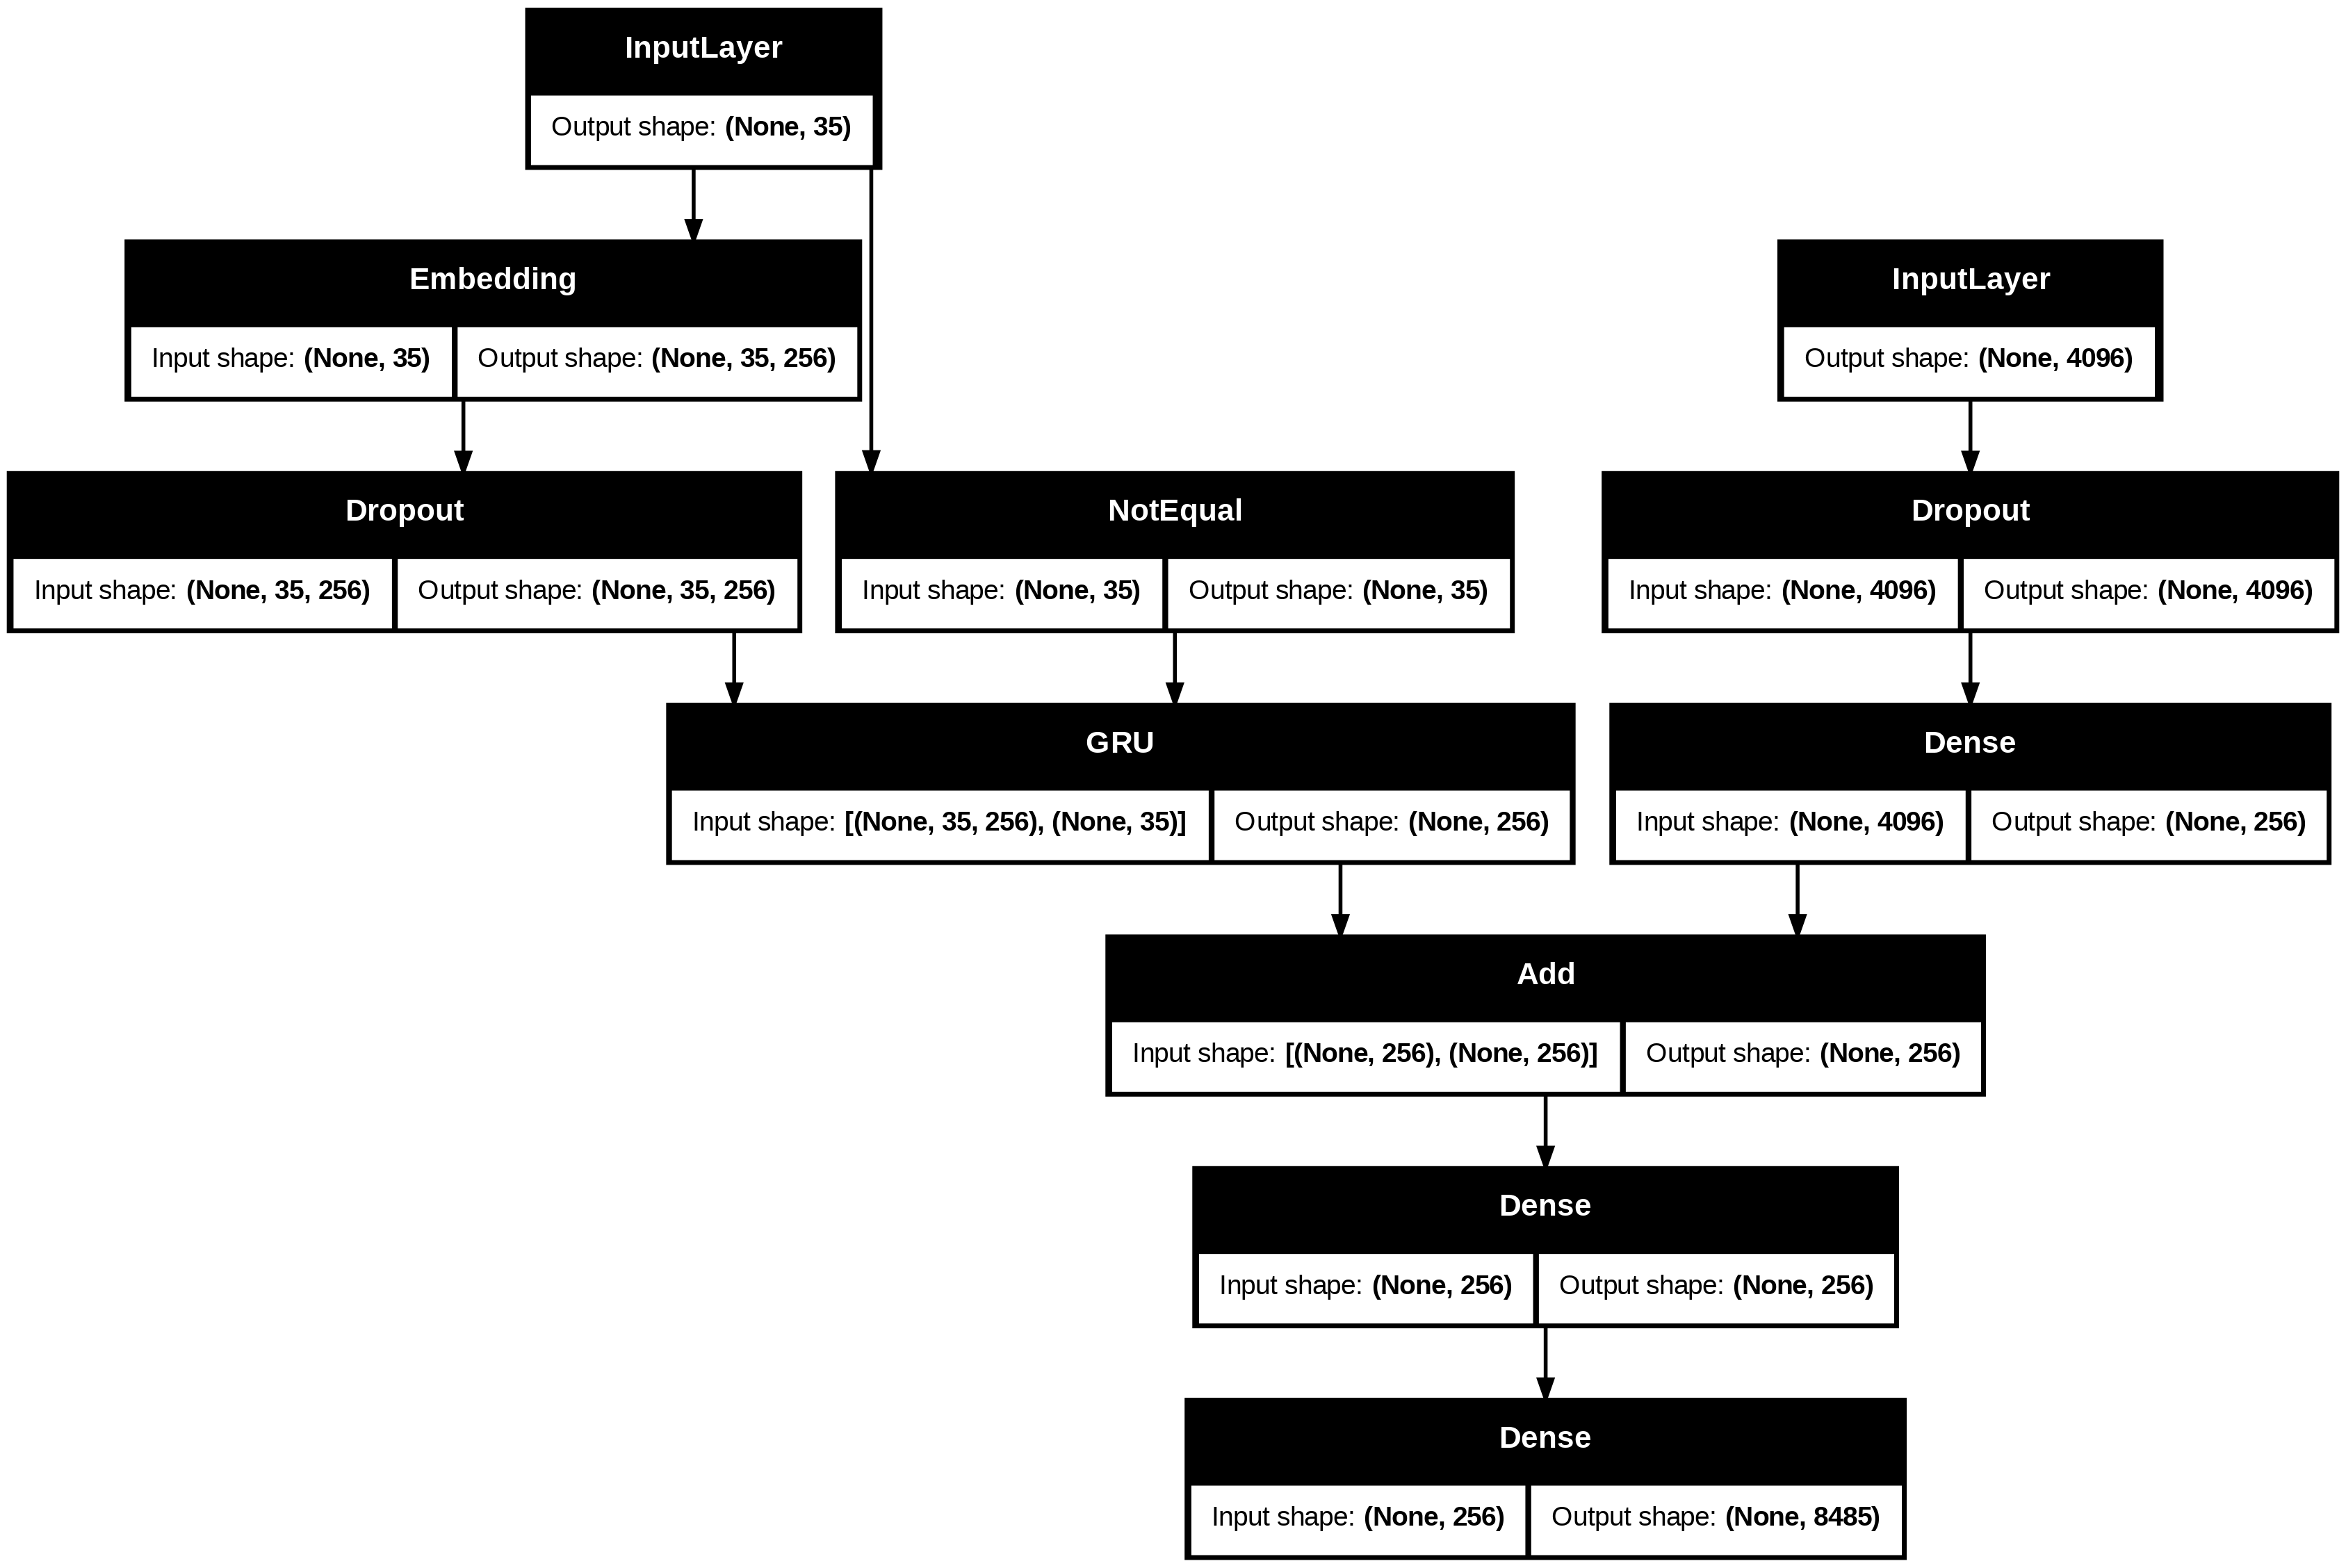

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

Now let us train the model

In [ ]:
!pip install pycocoevalcap
!pip install multiprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.9 MB/s eta 0:00:00



Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 71s 313ms/step - loss: 3.9862
Validation Loss: 3.8330
Generating captions for evaluation...


100%|██████████| 50/50 [00:02<00:00, 19.71it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 631, 'reflen': 517, 'guess': [631, 581, 531, 481], 'correct': [227, 78, 20, 2]}
ratio: 1.2205029013516044
Bleu_1: 0.360
Bleu_2: 0.220
Bleu_3: 0.122
Bleu_4: 0.052
computing METEOR score...
METEOR: 0.156
computing Rouge score...
ROUGE_L: 0.346
computing CIDEr score...
CIDEr: 0.300
computing SPICE score...
SPICE: 0.097
Epoch 1 Scores:
  Bleu_1: 0.3597
  Bleu_2: 0.2198
  Bleu_3: 0.1221
  Bleu_4: 0.0524
  METEOR: 0.1565
  ROUGE_L: 0.3465
  CIDEr: 0.3001
  SPICE: 0.0965

Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 294ms/step - loss: 3.4947
Validation Loss: 3.4254
Generating captions for evaluation...


100%|██████████| 50/50 [00:02<00:00, 22.39it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 565, 'reflen': 518, 'guess': [565, 515, 465, 415], 'correct': [245, 85, 31, 8]}
ratio: 1.090733590731485
Bleu_1: 0.434
Bleu_2: 0.268
Bleu_3: 0.168
Bleu_4: 0.098
computing METEOR score...
METEOR: 0.169
computing Rouge score...
ROUGE_L: 0.367
computing CIDEr score...
CIDEr: 0.381
computing SPICE score...
SPICE: 0.093
Epoch 2 Scores:
  Bleu_1: 0.4336
  Bleu_2: 0.2675
  Bleu_3: 0.1683
  Bleu_4: 0.0979
  METEOR: 0.1695
  ROUGE_L: 0.3668
  CIDEr: 0.3811
  SPICE: 0.0926

Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 67s 296ms/step - loss: 3.2163
Validation Loss: 3.1730
Generating captions for evaluation...


100%|██████████| 50/50 [00:02<00:00, 23.97it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 537, 'reflen': 525, 'guess': [537, 487, 437, 387], 'correct': [251, 87, 28, 6]}
ratio: 1.0228571428551945
Bleu_1: 0.467
Bleu_2: 0.289
Bleu_3: 0.175
Bleu_4: 0.095
computing METEOR score...
METEOR: 0.169
computing Rouge score...
ROUGE_L: 0.379
computing CIDEr score...
CIDEr: 0.358
computing SPICE score...
SPICE: 0.093
Epoch 3 Scores:
  Bleu_1: 0.4674
  Bleu_2: 0.2890
  Bleu_3: 0.1749
  Bleu_4: 0.0954
  METEOR: 0.1689
  ROUGE_L: 0.3790
  CIDEr: 0.3577
  SPICE: 0.0928

Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 65s 289ms/step - loss: 3.0170
Validation Loss: 2.9874
Generating captions for evaluation...


100%|██████████| 50/50 [00:02<00:00, 23.21it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 557, 'reflen': 525, 'guess': [557, 507, 457, 407], 'correct': [242, 86, 29, 6]}
ratio: 1.06095238095036
Bleu_1: 0.434
Bleu_2: 0.271
Bleu_3: 0.167
Bleu_4: 0.091
computing METEOR score...
METEOR: 0.163
computing Rouge score...
ROUGE_L: 0.358
computing CIDEr score...
CIDEr: 0.339
computing SPICE score...
SPICE: 0.089
Epoch 4 Scores:
  Bleu_1: 0.4345
  Bleu_2: 0.2715
  Bleu_3: 0.1672
  Bleu_4: 0.0911
  METEOR: 0.1628
  ROUGE_L: 0.3582
  CIDEr: 0.3390
  SPICE: 0.0887

Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 292ms/step - loss: 2.8636
Validation Loss: 2.8432
Generating captions for evaluation...


100%|██████████| 50/50 [00:01<00:00, 25.77it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 497, 'reflen': 501, 'guess': [497, 447, 397, 347], 'correct': [243, 80, 27, 6]}
ratio: 0.9920159680618922
Bleu_1: 0.485
Bleu_2: 0.293
Bleu_3: 0.180
Bleu_4: 0.100
computing METEOR score...
METEOR: 0.164
computing Rouge score...
ROUGE_L: 0.357
computing CIDEr score...
CIDEr: 0.324
computing SPICE score...
SPICE: 0.094
Epoch 5 Scores:
  Bleu_1: 0.4850
  Bleu_2: 0.2934
  Bleu_3: 0.1798
  Bleu_4: 0.0999
  METEOR: 0.1636
  ROUGE_L: 0.3569
  CIDEr: 0.3236
  SPICE: 0.0936

Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 291ms/step - loss: 2.7496
Validation Loss: 2.7330
Generating captions for evaluation...


100%|██████████| 50/50 [00:01<00:00, 26.59it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 483, 'reflen': 507, 'guess': [483, 433, 383, 333], 'correct': [252, 84, 24, 4]}
ratio: 0.9526627218916122
Bleu_1: 0.496
Bleu_2: 0.303
Bleu_3: 0.176
Bleu_4: 0.089
computing METEOR score...
METEOR: 0.169
computing Rouge score...
ROUGE_L: 0.370
computing CIDEr score...
CIDEr: 0.322
computing SPICE score...
SPICE: 0.093
Epoch 6 Scores:
  Bleu_1: 0.4964
  Bleu_2: 0.3027
  Bleu_3: 0.1761
  Bleu_4: 0.0889
  METEOR: 0.1691
  ROUGE_L: 0.3704
  CIDEr: 0.3216
  SPICE: 0.0931

Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 65s 290ms/step - loss: 2.6573
Validation Loss: 2.6459
Generating captions for evaluation...


100%|██████████| 50/50 [00:02<00:00, 20.61it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 498, 'reflen': 509, 'guess': [498, 448, 398, 348], 'correct': [249, 84, 27, 6]}
ratio: 0.9783889980334413
Bleu_1: 0.489
Bleu_2: 0.299
Bleu_3: 0.181
Bleu_4: 0.100
computing METEOR score...
METEOR: 0.164
computing Rouge score...
ROUGE_L: 0.364
computing CIDEr score...
CIDEr: 0.305
computing SPICE score...
SPICE: 0.094
Epoch 7 Scores:
  Bleu_1: 0.4891
  Bleu_2: 0.2995
  Bleu_3: 0.1812
  Bleu_4: 0.1001
  METEOR: 0.1642
  ROUGE_L: 0.3637
  CIDEr: 0.3047
  SPICE: 0.0940

Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 292ms/step - loss: 2.5744
Validation Loss: 2.5681
Generating captions for evaluation...


100%|██████████| 50/50 [00:02<00:00, 24.87it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 514, 'reflen': 527, 'guess': [514, 464, 414, 364], 'correct': [253, 77, 25, 4]}
ratio: 0.9753320683093447
Bleu_1: 0.480
Bleu_2: 0.279
Bleu_3: 0.166
Bleu_4: 0.084
computing METEOR score...
METEOR: 0.165
computing Rouge score...
ROUGE_L: 0.359
computing CIDEr score...
CIDEr: 0.288
computing SPICE score...
SPICE: 0.096
Epoch 8 Scores:
  Bleu_1: 0.4799
  Bleu_2: 0.2787
  Bleu_3: 0.1660
  Bleu_4: 0.0837
  METEOR: 0.1646
  ROUGE_L: 0.3592
  CIDEr: 0.2881
  SPICE: 0.0960

Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 67s 295ms/step - loss: 2.5113
Validation Loss: 2.5036
Generating captions for evaluation...


100%|██████████| 50/50 [00:02<00:00, 24.31it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 527, 'reflen': 515, 'guess': [527, 477, 427, 377], 'correct': [245, 79, 22, 3]}
ratio: 1.0233009708717995
Bleu_1: 0.465
Bleu_2: 0.277
Bleu_3: 0.158
Bleu_4: 0.075
computing METEOR score...
METEOR: 0.171
computing Rouge score...
ROUGE_L: 0.359
computing CIDEr score...
CIDEr: 0.315
computing SPICE score...
SPICE: 0.102
Epoch 9 Scores:
  Bleu_1: 0.4649
  Bleu_2: 0.2775
  Bleu_3: 0.1583
  Bleu_4: 0.0750
  METEOR: 0.1709
  ROUGE_L: 0.3592
  CIDEr: 0.3148
  SPICE: 0.1024

Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 67s 296ms/step - loss: 2.4504
Validation Loss: 2.4447
Generating captions for evaluation...


100%|██████████| 50/50 [00:02<00:00, 20.94it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 558, 'reflen': 535, 'guess': [558, 508, 458, 408], 'correct': [266, 96, 34, 7]}
ratio: 1.042990654203658
Bleu_1: 0.477
Bleu_2: 0.300
Bleu_3: 0.188
Bleu_4: 0.103
computing METEOR score...
METEOR: 0.177
computing Rouge score...
ROUGE_L: 0.388
computing CIDEr score...
CIDEr: 0.347
computing SPICE score...
SPICE: 0.106
Epoch 10 Scores:
  Bleu_1: 0.4767
  Bleu_2: 0.3001
  Bleu_3: 0.1884
  Bleu_4: 0.1035
  METEOR: 0.1768
  ROUGE_L: 0.3875
  CIDEr: 0.3468
  SPICE: 0.1056

Epoch 11/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 293ms/step - loss: 2.3993
Validation Loss: 2.3910
Generating captions for evaluation...


100%|██████████| 50/50 [00:01<00:00, 25.75it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 493, 'reflen': 500, 'guess': [493, 443, 393, 343], 'correct': [244, 87, 27, 5]}
ratio: 0.985999999998028
Bleu_1: 0.488
Bleu_2: 0.307
Bleu_3: 0.186
Bleu_4: 0.098
computing METEOR score...
METEOR: 0.168
computing Rouge score...
ROUGE_L: 0.374
computing CIDEr score...
CIDEr: 0.309
computing SPICE score...
SPICE: 0.097
Epoch 11 Scores:
  Bleu_1: 0.4880
  Bleu_2: 0.3074
  Bleu_3: 0.1857
  Bleu_4: 0.0979
  METEOR: 0.1685
  ROUGE_L: 0.3738
  CIDEr: 0.3093
  SPICE: 0.0974

Epoch 12/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 291ms/step - loss: 2.3508
Validation Loss: 2.3426
Generating captions for evaluation...


100%|██████████| 50/50 [00:01<00:00, 25.60it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 503, 'reflen': 513, 'guess': [503, 453, 403, 353], 'correct': [252, 84, 31, 6]}
ratio: 0.9805068226101745
Bleu_1: 0.491
Bleu_2: 0.299
Bleu_3: 0.189
Bleu_4: 0.103
computing METEOR score...
METEOR: 0.169
computing Rouge score...
ROUGE_L: 0.370
computing CIDEr score...
CIDEr: 0.351
computing SPICE score...
SPICE: 0.100
Epoch 12 Scores:
  Bleu_1: 0.4911
  Bleu_2: 0.2988
  Bleu_3: 0.1888
  Bleu_4: 0.1029
  METEOR: 0.1689
  ROUGE_L: 0.3698
  CIDEr: 0.3509
  SPICE: 0.1000

Epoch 13/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 292ms/step - loss: 2.3028
Validation Loss: 2.2945
Generating captions for evaluation...


100%|██████████| 50/50 [00:01<00:00, 25.73it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 497, 'reflen': 510, 'guess': [497, 447, 397, 347], 'correct': [243, 92, 36, 9]}
ratio: 0.9745098039196578
Bleu_1: 0.476
Bleu_2: 0.309
Bleu_3: 0.204
Bleu_4: 0.121
computing METEOR score...
METEOR: 0.175
computing Rouge score...
ROUGE_L: 0.368
computing CIDEr score...
CIDEr: 0.359
computing SPICE score...
SPICE: 0.115
Epoch 13 Scores:
  Bleu_1: 0.4763
  Bleu_2: 0.3090
  Bleu_3: 0.2036
  Bleu_4: 0.1208
  METEOR: 0.1748
  ROUGE_L: 0.3680
  CIDEr: 0.3590
  SPICE: 0.1154

Epoch 14/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 292ms/step - loss: 2.2611
Validation Loss: 2.2564
Generating captions for evaluation...


100%|██████████| 50/50 [00:01<00:00, 27.46it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 466, 'reflen': 491, 'guess': [466, 416, 366, 316], 'correct': [234, 86, 31, 7]}
ratio: 0.9490835030530569
Bleu_1: 0.476
Bleu_2: 0.305
Bleu_3: 0.196
Bleu_4: 0.112
computing METEOR score...
METEOR: 0.180
computing Rouge score...
ROUGE_L: 0.380
computing CIDEr score...
CIDEr: 0.333
computing SPICE score...
SPICE: 0.097
Epoch 14 Scores:
  Bleu_1: 0.4759
  Bleu_2: 0.3054
  Bleu_3: 0.1956
  Bleu_4: 0.1120
  METEOR: 0.1798
  ROUGE_L: 0.3800
  CIDEr: 0.3330
  SPICE: 0.0970

Epoch 15/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 67s 294ms/step - loss: 2.2232
Validation Loss: 2.2198
Generating captions for evaluation...


100%|██████████| 50/50 [00:01<00:00, 26.20it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 489, 'reflen': 514, 'guess': [489, 439, 389, 339], 'correct': [249, 77, 24, 6]}
ratio: 0.9513618677024293
Bleu_1: 0.484
Bleu_2: 0.284
Bleu_3: 0.168
Bleu_4: 0.094
computing METEOR score...
METEOR: 0.172
computing Rouge score...
ROUGE_L: 0.372
computing CIDEr score...
CIDEr: 0.292
computing SPICE score...
SPICE: 0.097
Epoch 15 Scores:
  Bleu_1: 0.4838
  Bleu_2: 0.2840
  Bleu_3: 0.1678
  Bleu_4: 0.0944
  METEOR: 0.1722
  ROUGE_L: 0.3715
  CIDEr: 0.2919
  SPICE: 0.0972

Epoch 16/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 67s 295ms/step - loss: 2.1829
Validation Loss: 2.1822
Generating captions for evaluation...


100%|██████████| 50/50 [00:01<00:00, 25.66it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 498, 'reflen': 508, 'guess': [498, 448, 398, 348], 'correct': [239, 76, 22, 5]}
ratio: 0.9803149606279915
Bleu_1: 0.470
Bleu_2: 0.280
Bleu_3: 0.162
Bleu_4: 0.088
computing METEOR score...
METEOR: 0.165
computing Rouge score...
ROUGE_L: 0.364
computing CIDEr score...
CIDEr: 0.290
computing SPICE score...
SPICE: 0.097
Epoch 16 Scores:
  Bleu_1: 0.4704
  Bleu_2: 0.2797
  Bleu_3: 0.1618
  Bleu_4: 0.0879
  METEOR: 0.1652
  ROUGE_L: 0.3636
  CIDEr: 0.2896
  SPICE: 0.0972

Epoch 17/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 294ms/step - loss: 2.1466
Validation Loss: 2.1497
Generating captions for evaluation...


100%|██████████| 50/50 [00:02<00:00, 24.79it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 518, 'reflen': 508, 'guess': [518, 468, 418, 368], 'correct': [244, 81, 26, 6]}
ratio: 1.0196850393680714
Bleu_1: 0.471
Bleu_2: 0.286
Bleu_3: 0.172
Bleu_4: 0.095
computing METEOR score...
METEOR: 0.170
computing Rouge score...
ROUGE_L: 0.370
computing CIDEr score...
CIDEr: 0.339
computing SPICE score...
SPICE: 0.099
Epoch 17 Scores:
  Bleu_1: 0.4710
  Bleu_2: 0.2855
  Bleu_3: 0.1718
  Bleu_4: 0.0954
  METEOR: 0.1699
  ROUGE_L: 0.3700
  CIDEr: 0.3390
  SPICE: 0.0994

Epoch 18/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 293ms/step - loss: 2.1136
Validation Loss: 2.1187
Generating captions for evaluation...


100%|██████████| 50/50 [00:01<00:00, 25.82it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 489, 'reflen': 498, 'guess': [489, 439, 389, 339], 'correct': [241, 85, 31, 9]}
ratio: 0.9819277108414017
Bleu_1: 0.484
Bleu_2: 0.303
Bleu_3: 0.193
Bleu_4: 0.117
computing METEOR score...
METEOR: 0.173
computing Rouge score...
ROUGE_L: 0.374
computing CIDEr score...
CIDEr: 0.301
computing SPICE score...
SPICE: 0.102
Epoch 18 Scores:
  Bleu_1: 0.4839
  Bleu_2: 0.3033
  Bleu_3: 0.1931
  Bleu_4: 0.1170
  METEOR: 0.1726
  ROUGE_L: 0.3740
  CIDEr: 0.3013
  SPICE: 0.1016

Epoch 19/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 293ms/step - loss: 2.0843
Validation Loss: 2.0875
Generating captions for evaluation...


100%|██████████| 50/50 [00:01<00:00, 26.82it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 479, 'reflen': 502, 'guess': [479, 429, 379, 329], 'correct': [250, 91, 28, 8]}
ratio: 0.9541832669303701
Bleu_1: 0.497
Bleu_2: 0.317
Bleu_3: 0.192
Bleu_4: 0.113
computing METEOR score...
METEOR: 0.185
computing Rouge score...
ROUGE_L: 0.381
computing CIDEr score...
CIDEr: 0.322
computing SPICE score...
SPICE: 0.095
Epoch 19 Scores:
  Bleu_1: 0.4975
  Bleu_2: 0.3171
  Bleu_3: 0.1920
  Bleu_4: 0.1132
  METEOR: 0.1848
  ROUGE_L: 0.3811
  CIDEr: 0.3221
  SPICE: 0.0952

Epoch 20/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 293ms/step - loss: 2.0569
Validation Loss: 2.0612
Generating captions for evaluation...


100%|██████████| 50/50 [00:01<00:00, 26.36it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 483, 'reflen': 500, 'guess': [483, 433, 383, 333], 'correct': [233, 76, 26, 7]}
ratio: 0.9659999999980681
Bleu_1: 0.466
Bleu_2: 0.281
Bleu_3: 0.173
Bleu_4: 0.101
computing METEOR score...
METEOR: 0.171
computing Rouge score...
ROUGE_L: 0.374
computing CIDEr score...
CIDEr: 0.305
computing SPICE score...
SPICE: 0.092
Epoch 20 Scores:
  Bleu_1: 0.4657
  Bleu_2: 0.2809
  Bleu_3: 0.1729
  Bleu_4: 0.1012
  METEOR: 0.1713
  ROUGE_L: 0.3743
  CIDEr: 0.3048
  SPICE: 0.0923


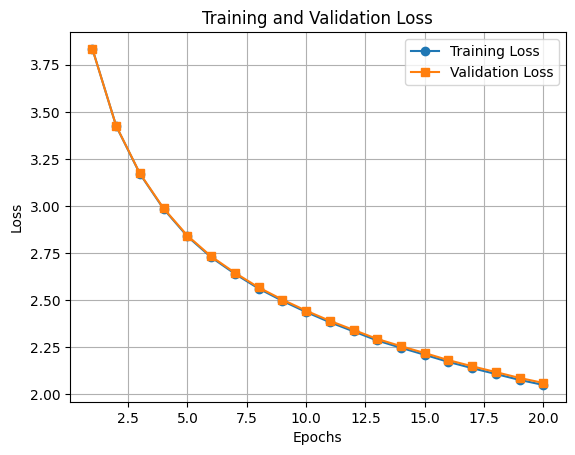

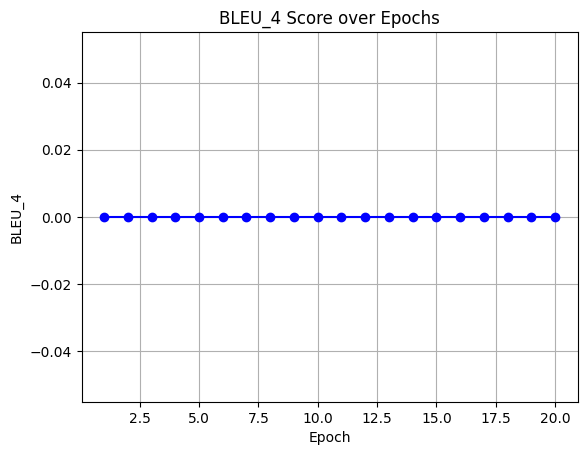

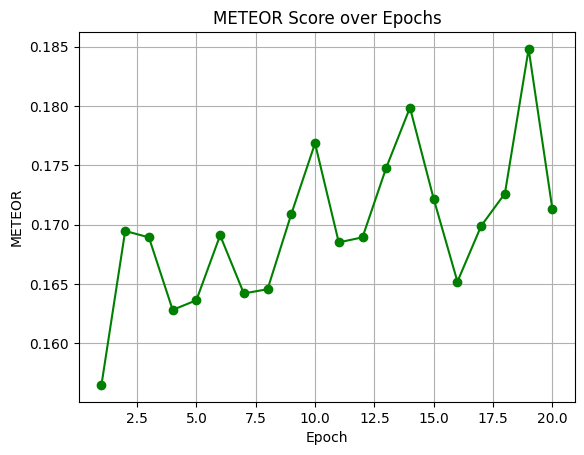

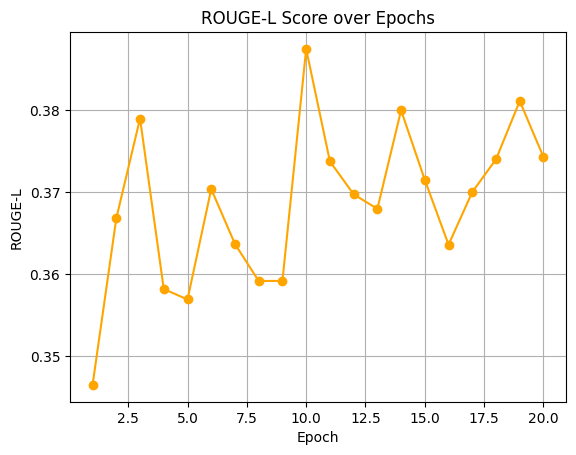

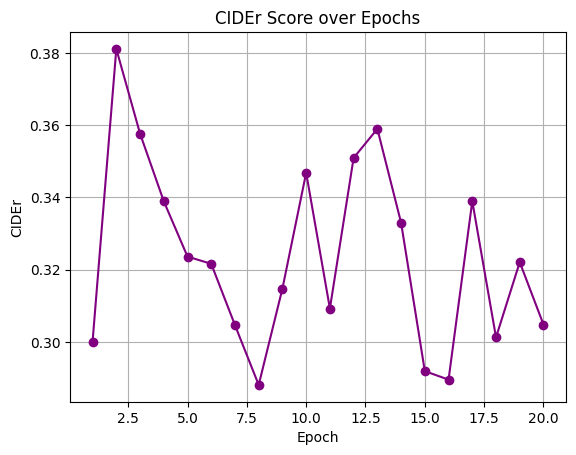

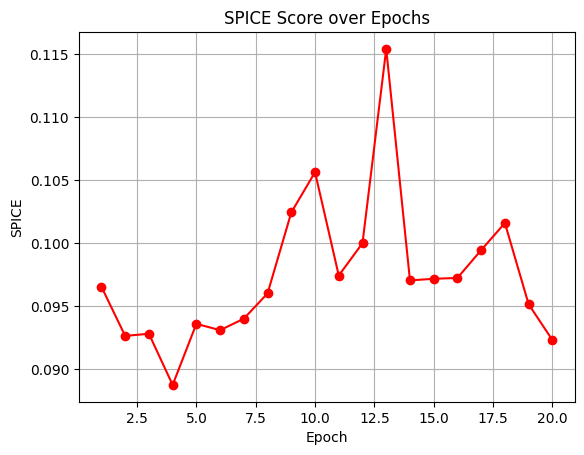

In [ ]:
# Optimized version of your image captioning training and evaluation loop

import matplotlib.pyplot as plt
import numpy as np
import json
from pycocoevalcap.eval import COCOEvalCap
from pycocotools.coco import COCO
import os
import copy
import ssl
import tensorflow as tf
import gc
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import mixed_precision
from tqdm import tqdm

# Enable mixed precision for memory optimization
mixed_precision.set_global_policy('mixed_float16')

# SSL context fix for COCOEval
def create_unverified_ssl_context():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

# Parameters
epochs = 20
batch_size = 32

# Reduce validation set
split = int(len(image_ids) * 0.90)
train_ids = image_ids[:split]
test_ids = image_ids[split:]
val_ids = train_ids[:50]  # Reduced for RAM
train_ids = train_ids[50:]

steps = len(train_ids) // batch_size
val_steps = len(val_ids) // batch_size

train_loss_plot, val_loss_plot = [], []
bleu_scores, meteor_scores, rouge_scores, cider_scores, spice_scores = [], [], [], [], []

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

@tf.function(reduce_retracing=True)
def wrapped_predict(model, image, sequence):
    return model([image, sequence], training=False)

def predict_caption(model, image, tokenizer, model_max_length):
    in_text = 'startseq'
    for _ in range(model_max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=model_max_length, padding='post')[0]
        sequence_tensor = tf.convert_to_tensor([sequence])
        image_tensor = tf.convert_to_tensor([image])
        yhat = wrapped_predict(model, image_tensor, sequence_tensor)
        yhat = tf.argmax(yhat[0]).numpy()
        word = idx_to_word(yhat, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text

def evaluate_captions(references, predictions):
    gts_path, res_path = "gts.json", "res.json"

    with open(gts_path, "w") as f:
        gts_list = []
        ann_id_counter = 0
        for img_id, caps in references.items():
            for cap_dict in caps:
                gts_list.append({"image_id": img_id, "caption": cap_dict["caption"], "id": ann_id_counter})
                ann_id_counter += 1
        json.dump(gts_list, f)

    with open(res_path, "w") as f:
        res_list = [{"image_id": img_id, "caption": caps[0]["caption"]} for img_id, caps in predictions.items() if caps]
        json.dump(res_list, f)

    dummy_images = [{"id": img_id} for img_id in predictions.keys()]
    gts_data_filtered = [ann for ann in gts_list if ann['image_id'] in predictions]

    coco_gt_format = {"info": {}, "annotations": gts_data_filtered, "images": dummy_images}
    coco_gt_path_formatted = "gts_formatted.json"
    with open(coco_gt_path_formatted, 'w') as f:
        json.dump(coco_gt_format, f)

    if dummy_images:
        coco = COCO(coco_gt_path_formatted)
        cocoRes = coco.loadRes(res_path)
        cocoEval = COCOEvalCap(coco, cocoRes)
        cocoEval.params['image_id'] = cocoRes.getImgIds()

        create_unverified_ssl_context()
        cocoEval.evaluate()

        os.remove(gts_path)
        os.remove(res_path)
        os.remove(coco_gt_path_formatted)

        return cocoEval.eval
    else:
        return {k: 0 for k in ['BLEU_1', 'BLEU_2', 'BLEU_3', 'BLEU_4', 'METEOR', 'ROUGE_L', 'CIDEr', 'SPICE']}

def generate_for_image(img_id):
    if img_id not in features:
        return None
    image_feature = features[img_id]
    if image_feature.shape == (1, 4096):
        image_feature = image_feature[0]
    caption = predict_caption(model, image_feature, tokenizer, max_length)
    return (img_id, caption)

for i in range(epochs):
    print(f"\nEpoch {i+1}/{epochs}")
    generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    train_loss_plot.append(history.history['loss'][0])

    if val_steps > 0:
        val_generator = data_generator(val_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)
        total_val_loss = 0
        for idx, (inputs, targets) in enumerate(val_generator):
            if idx >= val_steps:
                break
            loss = model.test_on_batch(inputs, targets)
            total_val_loss += loss
        avg_val_loss = total_val_loss / val_steps
        val_loss_plot.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
    else:
        print("Validation set too small.")
        val_loss_plot.append(None)

    print("Generating captions for evaluation...")
    results = []
    for img_id in tqdm(val_ids):
        result = generate_for_image(img_id)
        if result:
            results.append(result)

    predictions, references = {}, {}
    for result in results:
        img_id, caption = result
        predictions[img_id] = [{"caption": caption}]
        if img_id in mapping:
            references[img_id] = [{"caption": cap} for cap in mapping[img_id]]

    if predictions:
        scores = evaluate_captions(references, predictions)
        bleu_scores.append(scores.get('BLEU_4', 0))
        meteor_scores.append(scores.get('METEOR', 0))
        rouge_scores.append(scores.get('ROUGE_L', 0))
        cider_scores.append(scores.get('CIDEr', 0))
        spice_scores.append(scores.get('SPICE', 0))

        print(f"Epoch {i+1} Scores:")
        for metric, score in scores.items():
            print(f"  {metric}: {score:.4f}")
    else:
        print("No predictions to evaluate.")
        bleu_scores.append(0)
        meteor_scores.append(0)
        rouge_scores.append(0)
        cider_scores.append(0)
        spice_scores.append(0)

    gc.collect()
    tf.keras.backend.clear_session()

# Plot Loss
plt.figure()
plt.plot(range(1, epochs + 1), train_loss_plot, label='Training Loss', marker='o')
if all(v is not None for v in val_loss_plot):
    plt.plot(range(1, epochs + 1), val_loss_plot, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Metrics
metrics = [(bleu_scores, 'BLEU_4', 'blue'), (meteor_scores, 'METEOR', 'green'),
           (rouge_scores, 'ROUGE-L', 'orange'), (cider_scores, 'CIDEr', 'purple'),
           (spice_scores, 'SPICE', 'red')]

for scores, label, color in metrics:
    if scores:
        plt.figure()
        plt.plot(range(1, epochs + 1), scores, marker='o', color=color)
        plt.title(f'{label} Score over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(label)
        plt.grid(True)
        plt.show()

You can save the model in the working directory for reuse

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
         return word
    return None

Convert the predicted index from the model into a word

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text


Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

Generate custom captions

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs meeting on the beach endseq


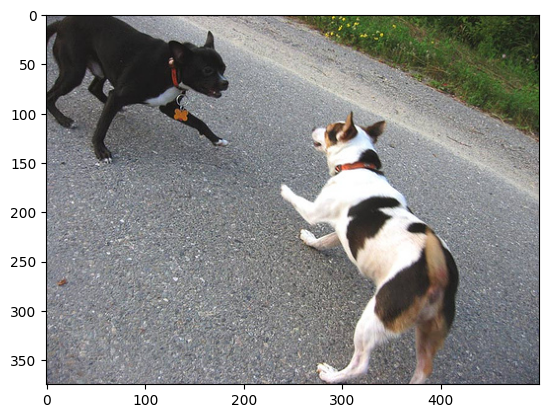

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

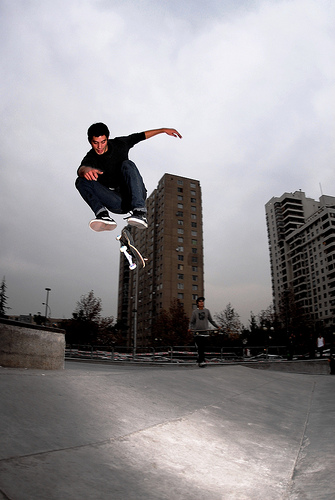

---------------------Actual---------------------
startseq guy is doing skateboard trick in the city endseq
startseq man does trick on his skateboard in an urban setting endseq
startseq man flips his skateboard in midair above the concrete ground endseq
startseq skateboarder doing jump near some apartment buildings endseq
startseq this rooftop skateboarder flies high doing trick to impress his friend endseq
--------------------Predicted--------------------
startseq skateboarder in the air endseq
Generated Caption: None


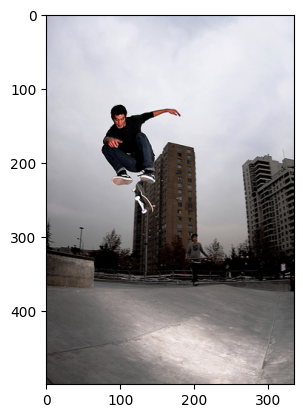

In [ ]:
import os
import random
from IPython.display import display
from PIL import Image

# Folder path containing images
image_folder = "/content/flickr8k/Images"

# Pick a random image file from the folder
random_image_file = random.choice(os.listdir(image_folder))

# Full path to the selected image
random_image_path = os.path.join(image_folder, random_image_file)

# Display the image
img = Image.open(random_image_path)
display(img)

# Generate caption
caption = generate_caption(random_image_file)
print("Generated Caption:", caption)
